In [1]:
#!ls
#%cd master-GAN/TimeGAN
%reload_ext autoreload
#!pip install -r requirements.txt

In [2]:
%autoreload
from architectures.RTSGAN import *
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)

trainset = DatasetSinus(num=600, seq_len=100, alpha=0.7, noise=0)
testset = DatasetSinus(num=600, seq_len=100, alpha=0.7, noise=0)
#stocks_data = google_data_loading(100)

#trainset =DatasetStocks(stocks_data[:-300])
#testset =DatasetStocks(stocks_data[-300:])
print(len(testset))
print(testset[0][0].size())

sin1 freq:[1, 3], phase:[-3.141592653589793, 0]
sin2 freq:[4, 6], phase:[0, 3.141592653589793]
sin1 freq:[1, 3], phase:[-3.141592653589793, 0]
sin2 freq:[4, 6], phase:[0, 3.141592653589793]
600
torch.Size([100, 3])


In [ ]:
%autoreload
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/RTSGAN",
    name="rtsgan",
    tags=[],
    description="test",
    source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_rtsgan.pt",
    "n_epochs": 1000,
    "l_rate": 0.0001,
    "l_rate_ae": 0.001,
    "batch_size": 16,
    "num_layers": 2, # only affects the autoencoder
    "hidden_dim": 30,
    "spectralnorm": True,
    "optimizer": "RMSprop", # RMSprop
    "dis_thresh": 0.15,
    "d_steps": 15,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
    "optimizer_ae": "Adam",
}
params["Z_dim"] = (params["num_layers"] +1) * params["hidden_dim"]
run["parameters"] = params

model = RTSGAN(params)
rtsgan_trainer(model, trainset, params, neptune_logger=run, continue_training=False)

# Generate random synthetic data
gen_z = rtsgan_generator(model, params)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-80
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Using optimizer: RMSprop

Start Embedding Network Training


Epoch: 349, Loss: 0.0016: 100%|██████████| 350/350 [04:53<00:00,  1.19it/s]



Start GAN Training


Epoch: 861, G: 3.6488, D: 2.5172:  86%|████████▌ | 862/1000 [07:29<01:13,  1.87it/s] 

In [82]:
gen_z = rtsgan_generator(model, params)


Generating Data...Done


In [83]:
from metrics import compare_sin3_generation, sinkhorn_distance, MMD
mse_error = compare_sin3_generation(gen_z, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
n=4
x = torch.tensor(gen_z)#[:10, :, :1]
y = testset[:][0]#[:10, :, 2:3]
wass_dist = sinkhorn_distance(x,y)
mmd = MMD(x,y)
print(f"Mean Wasserstein/Sinkhorn distance: {wass_dist.mean():.4f} ± {wass_dist.std():.4f}")
print(f"Mean MMD: {mmd.mean():.4f} ± {mmd.std():.4f}")

MSE Error: 0.00564
Mean Wasserstein/Sinkhorn distance: 0.0128 ± 0.0054
Mean MMD: 0.0125 ± 0.0018


In [68]:
wass_dist

tensor([0.0218, 0.0055, 0.0082, 0.0254, 0.0283, 0.0247, 0.0753, 0.0052, 0.0055,
        0.0021])

In [45]:
N, M = (100, 100) if not False else (50000, 50000)
dtype= torch.FloatTensor
# Generate some kind of 4d-helix:
t = torch.linspace(0, 2 * np.pi, N).type(dtype)
X_i = (
    torch.stack((t * (2 * t).cos() / 7, t * (2 * t).sin() / 7, t / 7, t ** 2 / 50))
    .t()
    .contiguous()
)
X_i = X_i + 0.05 * torch.randn(N, 4).type(dtype)  # + some noise

# The y_j's are sampled non-uniformly on the unit sphere of R^4:
Y_j = torch.randn(M, 4).type(dtype)
Y_j[:, 0] += 2
Y_j = Y_j / (1e-4 + Y_j.norm(dim=1, keepdim=True))

In [46]:
Y_j.size(), X_i.size()

(torch.Size([100, 4]), torch.Size([100, 4]))

In [47]:
sinkhorn_distance(X_i,Y_j)

tensor(0.5083)

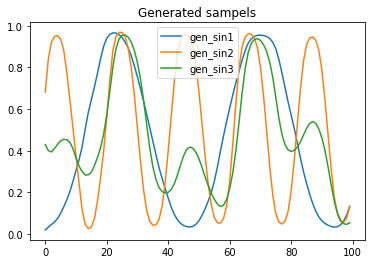

In [37]:
sample = 6
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

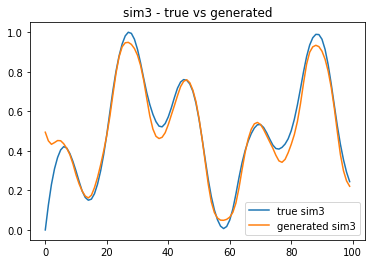

In [38]:
sample = 4
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], alpha=0.7, noise=0)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

In [20]:
%autoreload
from metrics import compare_sin3_generation
compare_sin3_generation(gen_z, 0.7, 0)

tensor(0.0057, dtype=torch.float64)

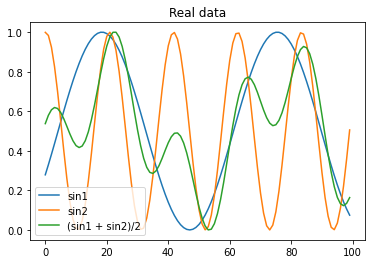

In [23]:
sample = trainset.__getitem__(2)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()